In [1]:
from pathlib import Path
import numpy as np
import cv2
import os
from skimage.feature import local_binary_pattern
from skimage.util.shape import view_as_blocks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Path to dataset
root = Path(r'C:\Users\Rostyslav\Desktop\term_paper\fer2013')
train_dir = root / 'train'
test_dir  = root / 'test'

# Check if such folders exist
print("Train dir exists:", train_dir.exists())
print("Test dir exists:", test_dir.exists())

# Emotions classification list
if train_dir.exists():
    classes = sorted([d for d in os.listdir(train_dir) if (train_dir / d).is_dir()])
    print(f"\nFound {len(classes)} emotion classes: {classes}")
else:
    print("❌ Train directory not found! Check the path.")

Train dir exists: True
Test dir exists: True

Found 7 emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


✅ Loader function defined.


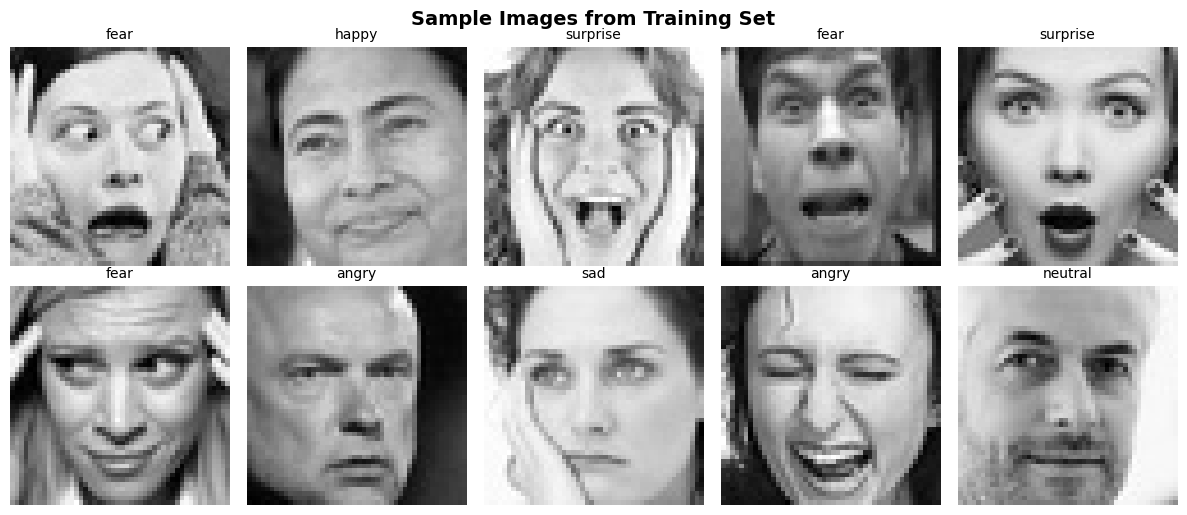


Loaded 28709 images from training set.
Image shape: (48, 48)
Classes: [np.str_('angry'), np.str_('disgust'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprise')]


In [2]:
import matplotlib.pyplot as plt

def load_split(split_dir):
    """Images load"""
    X, y = [], []
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = split_dir / class_name
        if not class_dir.is_dir():
            continue
        for fname in os.listdir(class_dir):
            fpath = class_dir / fname
            img = cv2.imread(str(fpath), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (48, 48), interpolation=cv2.INTER_AREA)
            X.append(img)
            y.append(class_name)
    return np.array(X), np.array(y)

print("✅ Loader function defined.")

# Load train data for visualization
X_sample, y_sample = load_split(train_dir)

# Show some random examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

np.random.seed(42)
random_indices = np.random.choice(len(X_sample), size=10, replace=False)

for i, idx in enumerate(random_indices):
    axes[i].imshow(X_sample[idx], cmap='gray')
    axes[i].set_title(f'{y_sample[idx]}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Images from Training Set', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"\nLoaded {len(X_sample)} images from training set.")
print(f"Image shape: {X_sample[0].shape}")
print(f"Classes: {sorted(np.unique(y_sample))}")


In [3]:
X_train, y_train = load_split(train_dir)
X_test,  y_test  = load_split(test_dir)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Classes: {sorted(np.unique(y_train))}")

Train set: (28709, 48, 48), Test set: (7178, 48, 48)
Classes: [np.str_('angry'), np.str_('disgust'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprise')]


In [4]:
val_size = 3589
val_ratio = val_size / len(X_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=val_ratio, 
    stratify=y_train, 
    random_state=42
)

print("✅ Split created to match report:")
print(f"  Train:      {X_train.shape} ({len(X_train)} images)")
print(f"  Validation: {X_val.shape} ({len(X_val)} images)")
print(f"  Test:       {X_test.shape} ({len(X_test)} images)")
print(f"\nFinal split: ~25,120 / 3,589 / 7,178 (train / val / test)")

✅ Split created to match report:
  Train:      (25120, 48, 48) (25120 images)
  Validation: (3589, 48, 48) (3589 images)
  Test:       (7178, 48, 48) (7178 images)

Final split: ~25,120 / 3,589 / 7,178 (train / val / test)


In [5]:
def preprocess(img):
    """
    Normalization, dividing pixels by 255.
    For LBP+SVM augmentation will not be used.
    """
    return (img / 255.0).astype(np.float32)

print("Preprocessing images (normalization only)...")
X_train_p = np.stack([preprocess(im) for im in X_train])
X_val_p   = np.stack([preprocess(im) for im in X_val])
X_test_p  = np.stack([preprocess(im) for im in X_test])

print(f"\n✅ Preprocessing complete:")
print(f"  Train:      {X_train_p.shape}, dtype: {X_train_p.dtype}")
print(f"  Validation: {X_val_p.shape}, dtype: {X_val_p.dtype}")
print(f"  Test:       {X_test_p.shape}, dtype: {X_test_p.dtype}")
print(f"\n  Pixel range: [{X_train_p.min():.4f}, {X_train_p.max():.4f}]")
print(f"  Mean: {X_train_p.mean():.4f}, Std: {X_train_p.std():.4f}")

Preprocessing images (normalization only)...

✅ Preprocessing complete:
  Train:      (25120, 48, 48), dtype: float32
  Validation: (3589, 48, 48), dtype: float32
  Test:       (7178, 48, 48), dtype: float32

  Pixel range: [0.0000, 1.0000]
  Mean: 0.5077, Std: 0.2551


In [6]:
from skimage import img_as_ubyte

def lbp_histogram(img, P=8, R=1, grid=(7,7), method="uniform"):
    """
    Extracts LBP features by dividing the image into a grid and computing histograms.
    
    Parameters:
    - img: input grayscale image (normalized float)
    - P: number of neighboring pixels (default: 8)
    - R: radius of the circle (default: 1)
    - grid: grid dimensions for spatial binning (default: 7x7)
    - method: LBP method ('uniform' for compact feature space)
    
    Returns:
    - 1D feature vector (concatenated histograms from each grid cell)
    """
    # Convert to uint8 to avoid scikit-image warning
    img_uint8 = img_as_ubyte(img)
    
    # Compute LBP
    lbp = local_binary_pattern(img_uint8, P=P, R=R, method=method)
    n_bins = P + 2  # For uniform LBP: P + 2 bins
    
    # Crop image to fit grid dimensions
    h, w = img_uint8.shape
    gh, gw = grid
    h2, w2 = (h // gh) * gh, (w // gw) * gw
    lbp = lbp[:h2, :w2]
    
    # Divide into blocks
    cell_h, cell_w = h2 // gh, w2 // gw
    blocks = view_as_blocks(lbp, block_shape=(cell_h, cell_w))
    
    # Extract histograms from each block
    feats = []
    for i in range(gh):
        for j in range(gw):
            cell = blocks[i, j]
            hist, _ = np.histogram(cell.ravel(), bins=n_bins, range=(0, n_bins), density=True)
            feats.append(hist)
    
    return np.concatenate(feats, axis=0)

print("✅ LBP histogram function defined.")
print(f"   Parameters: P=8, R=1, grid=(7,7), method='uniform'")
print(f"   Feature vector size: {(8+2) * 7 * 7} dimensions per image")

✅ LBP histogram function defined.
   Parameters: P=8, R=1, grid=(7,7), method='uniform'
   Feature vector size: 490 dimensions per image


In [7]:
# LBP parameters
P, R, GRID = 8, 1, (7, 7)

print("Extracting LBP features from all datasets...")
print(f"  Using P={P}, R={R}, grid={GRID}")

# Extract features for train, validation, and test sets
Xtr_lbp = np.vstack([lbp_histogram(im, P, R, GRID) for im in X_train_p])
Xva_lbp = np.vstack([lbp_histogram(im, P, R, GRID) for im in X_val_p])
Xte_lbp = np.vstack([lbp_histogram(im, P, R, GRID) for im in X_test_p])

print(f"\n✅ LBP feature extraction complete:")
print(f"  Train features:      {Xtr_lbp.shape}")
print(f"  Validation features: {Xva_lbp.shape}")
print(f"  Test features:       {Xte_lbp.shape}")
print(f"\n  Feature vector size: {Xtr_lbp.shape[1]} dimensions per image")

Extracting LBP features from all datasets...
  Using P=8, R=1, grid=(7, 7)

✅ LBP feature extraction complete:
  Train features:      (25120, 490)
  Validation features: (3589, 490)
  Test features:       (7178, 490)

  Feature vector size: 490 dimensions per image


In [8]:
# Encode string labels to integers
le = LabelEncoder()
ytr = le.fit_transform(y_train)
yva = le.transform(y_val)
yte = le.transform(y_test)

print("✅ Labels encoded:")
print(f"  Classes: {le.classes_}")
print(f"  Train labels: {ytr.shape}, Validation labels: {yva.shape}, Test labels: {yte.shape}")

# Compute class weights to address imbalance
classes = np.unique(ytr)
class_weights = compute_class_weight('balanced', classes=classes, y=ytr)
cw = {int(c): float(w) for c, w in zip(classes, class_weights)}

print(f"\n✅ Class weights computed (balanced):")
for idx, cls_name in enumerate(le.classes_):
    count = np.sum(ytr == idx)
    print(f"  {cls_name:8s}: weight={cw[idx]:.4f}, count={count:5d}")

print(f"\nNote: Higher weights for minority classes (e.g., disgust) to combat imbalance.")

✅ Labels encoded:
  Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
  Train labels: (25120,), Validation labels: (3589,), Test labels: (7178,)

✅ Class weights computed (balanced):
  angry   : weight=1.0265, count= 3496
  disgust : weight=9.4188, count=  381
  fear    : weight=1.0010, count= 3585
  happy   : weight=0.5684, count= 6313
  neutral : weight=0.8261, count= 4344
  sad     : weight=0.8492, count= 4226
  surprise: weight=1.2932, count= 2775

Note: Higher weights for minority classes (e.g., disgust) to combat imbalance.


In [9]:
print("Training Linear SVM classifier...")
print(f"  Using class-weighted loss (C=1.0)")

# Train Linear SVM with class weighting
svm = LinearSVC(C=1.0, class_weight=cw, max_iter=5000, dual=False, random_state=42)
svm.fit(Xtr_lbp, ytr)
# C=1.0: Regularization parameter (standard value)
# class_weight=cw: Uses the computed balanced weights
# max_iter=5000: Maximum iterations for convergence
# dual=False: Recommended for n_samples > n_features
# random_state=42: For reproducibility

print(f"\n✅ Training complete!")
print(f"  Model: Linear SVM with class weights")
print(f"  Training samples: {len(ytr)}")
print(f"  Feature dimension: {Xtr_lbp.shape[1]}")
print(f"  Number of classes: {len(le.classes_)}")


Training Linear SVM classifier...
  Using class-weighted loss (C=1.0)

✅ Training complete!
  Model: Linear SVM with class weights
  Training samples: 25120
  Feature dimension: 490
  Number of classes: 7


In [10]:
print("VALIDATION METRICS:")
print("-" * 60)
print(classification_report(yva, svm.predict(Xva_lbp), target_names=le.classes_, digits=4))

print("\nTEST METRICS:")
print("-" * 60)
print(classification_report(yte, svm.predict(Xte_lbp), target_names=le.classes_, digits=4))

print("\nTEST SET CONFUSION MATRIX:")
print("-" * 60)
print(confusion_matrix(yte, svm.predict(Xte_lbp)))

VALIDATION METRICS:
------------------------------------------------------------
              precision    recall  f1-score   support

       angry     0.2414    0.1543    0.1883       499
     disgust     0.0382    0.3091    0.0680        55
        fear     0.2596    0.1055    0.1500       512
       happy     0.4924    0.5355    0.5130       902
     neutral     0.3333    0.2512    0.2865       621
         sad     0.3242    0.2550    0.2854       604
    surprise     0.2987    0.5227    0.3802       396

    accuracy                         0.3199      3589
   macro avg     0.2840    0.3047    0.2673      3589
weighted avg     0.3401    0.3199    0.3171      3589


TEST METRICS:
------------------------------------------------------------
              precision    recall  f1-score   support

       angry     0.2583    0.1858    0.2162       958
     disgust     0.0572    0.4144    0.1005       111
        fear     0.1818    0.0820    0.1131      1024
       happy     0.5010    0.

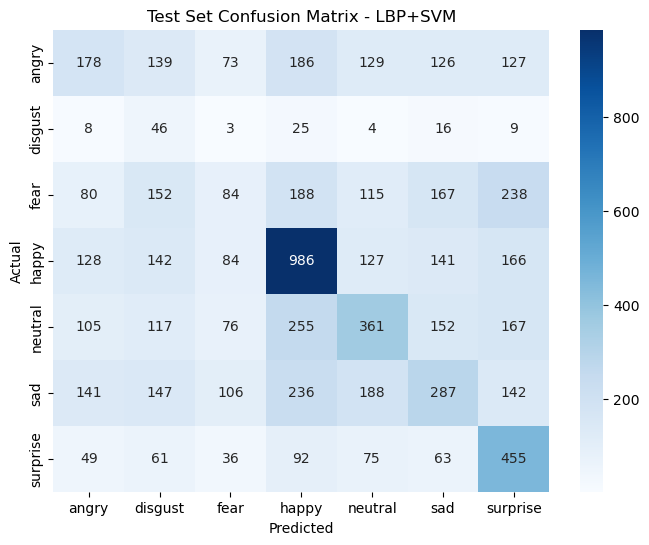

In [11]:
import seaborn as sns
cm = confusion_matrix(yte, svm.predict(Xte_lbp))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix - LBP+SVM')
plt.show()

In [14]:
import joblib
joblib.dump(X_train_p, 'X_train_p.joblib')
joblib.dump(X_val_p,   'X_val_p.joblib')
joblib.dump(X_test_p,  'X_test_p.joblib')

# Save extracted LBP features
joblib.dump(Xtr_lbp, 'Xtr_lbp.joblib')
joblib.dump(Xva_lbp, 'Xva_lbp.joblib')
joblib.dump(Xte_lbp, 'Xte_lbp.joblib')

# If y_train/y_val/y_test are string labels, save as-is:
joblib.dump(y_train, 'y_train.joblib')
joblib.dump(y_val,   'y_val.joblib')
joblib.dump(y_test,  'y_test.joblib')

# Also save encoded form if you wish (ytr/yva/yte):
joblib.dump(ytr, 'ytr.joblib')
joblib.dump(yva, 'yva.joblib')
joblib.dump(yte, 'yte.joblib')
joblib.dump(cw, 'class_weights.joblib')   # cw is the dictionary of class weights

['class_weights.joblib']

In [15]:
# Save model
joblib.dump(svm, 'lbp_linearsvm_fer2013.joblib')
joblib.dump(le,  'label_encoder.joblib')
print("Model and label encoder saved.")

Model and label encoder saved.


In [22]:
# CNN IMPLEMENTATION
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation     # for augmentation

In [21]:
# Load emotion label encoder
label_encoder = joblib.load("label_encoder.joblib")
num_classes = len(label_encoder.classes_)

# Load splits (float32, normalized [0,1], shape (N,48,48), labels as strings)
X_train = joblib.load("X_train_p.joblib")       # images
X_val   = joblib.load("X_val_p.joblib")
X_test  = joblib.load("X_test_p.joblib")
y_train = joblib.load("y_train.joblib")         # labels
y_val   = joblib.load("y_val.joblib")
y_test  = joblib.load("y_test.joblib")

# Encode labels (string -> int)
y_train_int = label_encoder.transform(y_train)
y_val_int   = label_encoder.transform(y_val)
y_test_int  = label_encoder.transform(y_test)

# One-hot encode for Keras
y_train_cat = to_categorical(y_train_int, num_classes)
y_val_cat   = to_categorical(y_val_int,   num_classes)
y_test_cat  = to_categorical(y_test_int,  num_classes)

print("Label classes:", label_encoder.classes_)
print('Train images:', X_train.shape, 'labels:', y_train_cat.shape)

Label classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Train images: (25120, 48, 48) labels: (25120, 7)


In [18]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn   = X_val[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]
print("Train images shape:", X_train_cnn.shape)

Train images shape: (25120, 48, 48, 1)


In [23]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.055),      # approx ±10 degrees
    RandomTranslation(0.1, 0.1) # up to ±10% in either direction
])

In [24]:
cnn_model = models.Sequential([
    layers.Input(shape=(48,48,1)),
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,246,567 (4.76 MB)

 Trainable params: 1,246,119 (4.75 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(num_classes)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_int)
cw_dict = {i: float(w) for i, w in enumerate(class_weights)}

cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Class weights:", cw_dict)

Class weights: {0: 1.0264792415822164, 1: 9.418822647169105, 2: 1.0009962143853357, 3: 0.568441537869702, 4: 0.8260983951591686, 5: 0.8491650327902103, 6: 1.2931788931788932}


In [31]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('cnn_best_model.keras', monitor='val_loss', save_best_only=True)

history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=100, batch_size=64,
    class_weight=cw_dict,
    callbacks=[earlystop, checkpoint],
    verbose=2
)

# Save explicitly after training if you want
# cnn_model.save('cnn_final_model.keras')

Epoch 1/100
393/393 - 82s - 209ms/step - accuracy: 0.4875 - loss: 1.3335 - val_accuracy: 0.5224 - val_loss: 1.2643
Epoch 2/100
393/393 - 80s - 204ms/step - accuracy: 0.4912 - loss: 1.3335 - val_accuracy: 0.5099 - val_loss: 1.2868
Epoch 3/100
393/393 - 83s - 211ms/step - accuracy: 0.4912 - loss: 1.3144 - val_accuracy: 0.4751 - val_loss: 1.3951
Epoch 4/100
393/393 - 85s - 217ms/step - accuracy: 0.4879 - loss: 1.3345 - val_accuracy: 0.5311 - val_loss: 1.2573
Epoch 5/100
393/393 - 84s - 213ms/step - accuracy: 0.4974 - loss: 1.2947 - val_accuracy: 0.5389 - val_loss: 1.2161
Epoch 6/100
393/393 - 142s - 362ms/step - accuracy: 0.4992 - loss: 1.3051 - val_accuracy: 0.5369 - val_loss: 1.2570
Epoch 7/100
393/393 - 141s - 360ms/step - accuracy: 0.5047 - loss: 1.2900 - val_accuracy: 0.5386 - val_loss: 1.2161
Epoch 8/100
393/393 - 143s - 363ms/step - accuracy: 0.5061 - loss: 1.2849 - val_accuracy: 0.5472 - val_loss: 1.1862
Epoch 9/100
393/393 - 142s - 361ms/step - accuracy: 0.5034 - loss: 1.2840 - v

In [34]:
# Get predicted probabilities for validation set
y_val_pred_prob = cnn_model.predict(X_val_cnn)
y_val_pred_int = np.argmax(y_val_pred_prob, axis=1)
y_val_true_int = np.argmax(y_val_cat, axis=1)

print("VALIDATION METRICS (CNN):")
print("-" * 60)
print(classification_report(
    y_val_true_int, y_val_pred_int, 
    target_names=label_encoder.classes_,
    digits=4
))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
VALIDATION METRICS (CNN):
------------------------------------------------------------
              precision    recall  f1-score   support

       angry     0.4834    0.5531    0.5159       499
     disgust     0.3051    0.3273    0.3158        55
        fear     0.5091    0.2188    0.3060       512
       happy     0.7993    0.7550    0.7765       902
     neutral     0.4571    0.7456    0.5667       621
         sad     0.4974    0.3129    0.3841       604
    surprise     0.6255    0.7803    0.6944       396

    accuracy                         0.5706      3589
   macro avg     0.5253    0.5276    0.5085      3589
weighted avg     0.5772    0.5706    0.5547      3589



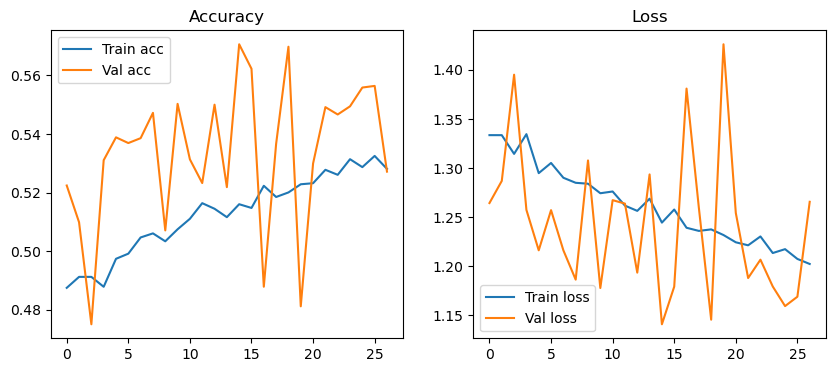

In [32]:
# Visualize training history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss'); plt.legend()
plt.show()

In [ ]:
# Load the best model if needed 
cnn_model = tf.keras.models.load_model('cnn_best_model.keras')

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step
TEST SET METRICS (CNN):
------------------------------------------------------------
              precision    recall  f1-score   support

       angry       0.45      0.53      0.49       958
     disgust       0.39      0.49      0.43       111
        fear       0.42      0.16      0.23      1024
       happy       0.82      0.78      0.80      1774
     neutral       0.44      0.74      0.55      1233
         sad       0.49      0.30      0.37      1247
    surprise       0.64      0.77      0.70       831

    accuracy                           0.56      7178
   macro avg       0.52      0.54      0.51      7178
weighted avg       0.56      0.56      0.54      7178



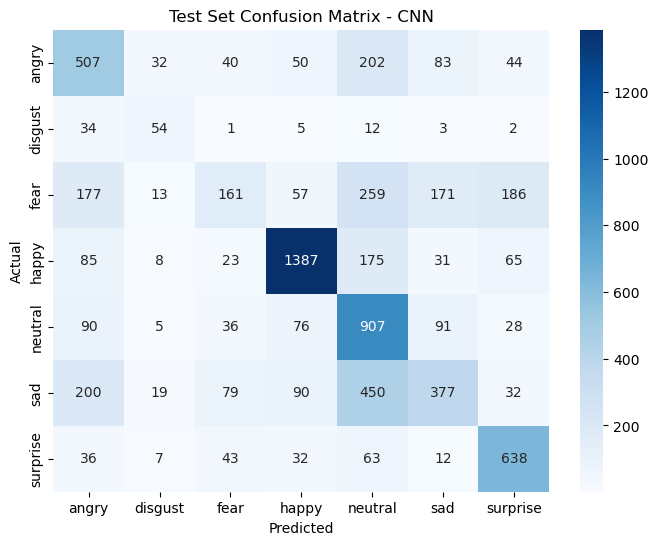

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_prob = cnn_model.predict(X_test_cnn)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_true_int = np.argmax(y_test_cat, axis=1)

print("TEST SET METRICS (CNN):")
print("-" * 60)
print(classification_report(y_true_int, y_pred_int, target_names=label_encoder.classes_))

# Compute confusion matrix for test set
cm = confusion_matrix(y_true_int, y_pred_int)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, 
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix - CNN')
plt.show()

In [36]:
joblib.dump(y_pred_int, 'cnn_test_pred_labels.joblib')
joblib.dump(cm, 'cnn_cnn_test_confmat.joblib')

['cnn_cnn_test_confmat.joblib']